In [96]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf


from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)


def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def calc_agreement(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus (everyone agrees).
    Lower value = High disagreement or mostly neutral news.
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    agreement = 1 - np.sqrt(1 - inner_val)
    
    return agreement

Device set to use cuda:0


In [97]:
data = pd.read_parquet('scraped_data.parquet')
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)


/tmp/ipykernel_12886/1598241461.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)


In [98]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

tech_crash_events = stock_anomaly.get_anomalies()

[*********************100%***********************]  5 of 5 completed


In [99]:
tech_crash_events['event'] = np.where(tech_crash_events.rolling_z_P>0,'positive','negative')

In [ ]:
data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data['title'].apply(finbert_sentiment).apply(pd.Series)

# data.to_parquet("scraped_data_finbert.parquet", compression="snappy")

In [101]:
# data = pd.read_parquet("scraped_data_finbert.parquet")

In [102]:
cond = (
    ((data['fb_positive']>0.6) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>0.6) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>0.6) & (data['sentiment']=='negative'))
)

data = data[cond]

KeyError: 'fb_positive'

In [ ]:
metrics = data.groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    agreement_index = calc_agreement,
    article_count = 'count'
)



In [ ]:
import yfinance as yf

def add_ts(metrics):
    '''maybe use stockanomaly functions'''
    
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]
    stocks_data = yf.Tickers(stocks)
    data = stocks_data.history('5y', interval="1d")['Close']

    prices_long = data.stack().reset_index()

    prices_long.columns = ['date','label','price']

    prices_long.sort_values(['label','date'],inplace=True)

    prices_long['date']=prices_long['date'].dt.date.astype(str)

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')

    return combined_df  

In [ ]:
def add_ts(metrics):
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]
    stocks_data = yf.Tickers(stocks)
    
    hist = stocks_data.history(period='5y', interval="1d")
    data_subset = hist[['Close', 'Volume']]
    
    prices_long = data_subset.stack(level=1).reset_index()
    
    prices_long.columns = ['date', 'label', 'price', 'volume']
    
    prices_long.sort_values('date',ascending=True,inplace=True)

    prices_long['log_delta_price'] = prices_long.groupby('label'
            )['price'].transform(lambda x: np.log(x/x.shift(1)))

    prices_long['log_volume'] = np.log(prices_long['volume'] + 1)

    prices_long.sort_values(['label', 'date'], inplace=True)
    prices_long['date'] = prices_long['date'].dt.date.astype(str)

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')

    combined_df['bullishness_shifted'] = combined_df['bullishness_index'].shift(1)
    combined_df['agreeement_shifted'] = combined_df['agreement_index'].shift(1)

    return combined_df.dropna()

In [ ]:
lbl = 'NVDA'
positive_dates = tech_crash_events[
    (tech_crash_events['event']=='positive') & (tech_crash_events['stock']==lbl)]['date']
negative_dates = tech_crash_events[
    (tech_crash_events['event']=='negative') & (tech_crash_events['stock']==lbl)]['date']

In [ ]:
combined_df = add_ts(metrics)
combined_df.head(5)

[*********************100%***********************]  5 of 5 completed


,date,label,price,bullishness_index,agreement_index,article_count
0,2021-01-19,AMD,89.449997,NaN,NaN,NaN
1,2021-01-20,AMD,88.750000,NaN,NaN,NaN
2,2021-01-21,AMD,91.529999,NaN,NaN,NaN
3,2021-01-22,AMD,92.790001,NaN,NaN,NaN
4,2021-01-25,AMD,94.129997,NaN,NaN,NaN


In [ ]:
negative_dates

113   2021-02-25
119   2022-08-08
122   2023-10-17
125   2024-04-19
127   2024-09-03
128   2025-01-07
129   2025-01-27
130   2025-02-27
Name: date, dtype: datetime64[ns]

In [ ]:
nvidia_look = combined_df[(combined_df['label']==lbl) & (combined_df['date'].isin(pd.to_datetime(negative_dates).dt.strftime('%Y-%m-%d')))]

In [ ]:
nvidia_look

,date,label,price,volume,log_delta_price,log_volume,bullishness_index,agreement_index,article_count,bullishness_shifted,agreeement_shifted
3332,2024-04-19,NVDA,76.161140,875198000,-0.105412,20.589961,-0.693147,0.002963,13.0,0.693147,0.007843
3425,2024-09-03,NVDA,107.953789,477155100,-0.100097,19.983352,0.000000,0.000000,1.0,0.000000,0.000000
3512,2025-01-07,NVDA,140.101669,351782200,-0.064186,19.678523,1.386294,0.079739,23.0,1.609438,0.179348
3524,2025-01-27,NVDA,118.387611,818830900,-0.185946,20.523388,0.182322,0.001732,17.0,1.098612,0.133975
3546,2025-02-27,NVDA,120.117149,443175800,-0.088592,19.909477,0.628609,0.024219,32.0,0.451985,0.007843


In [ ]:
((nvidia_look.log_delta_price<0) & (nvidia_look.bullishness_shifted<-0.1)).sum()

np.int64(0)

np.float64(18562.0)

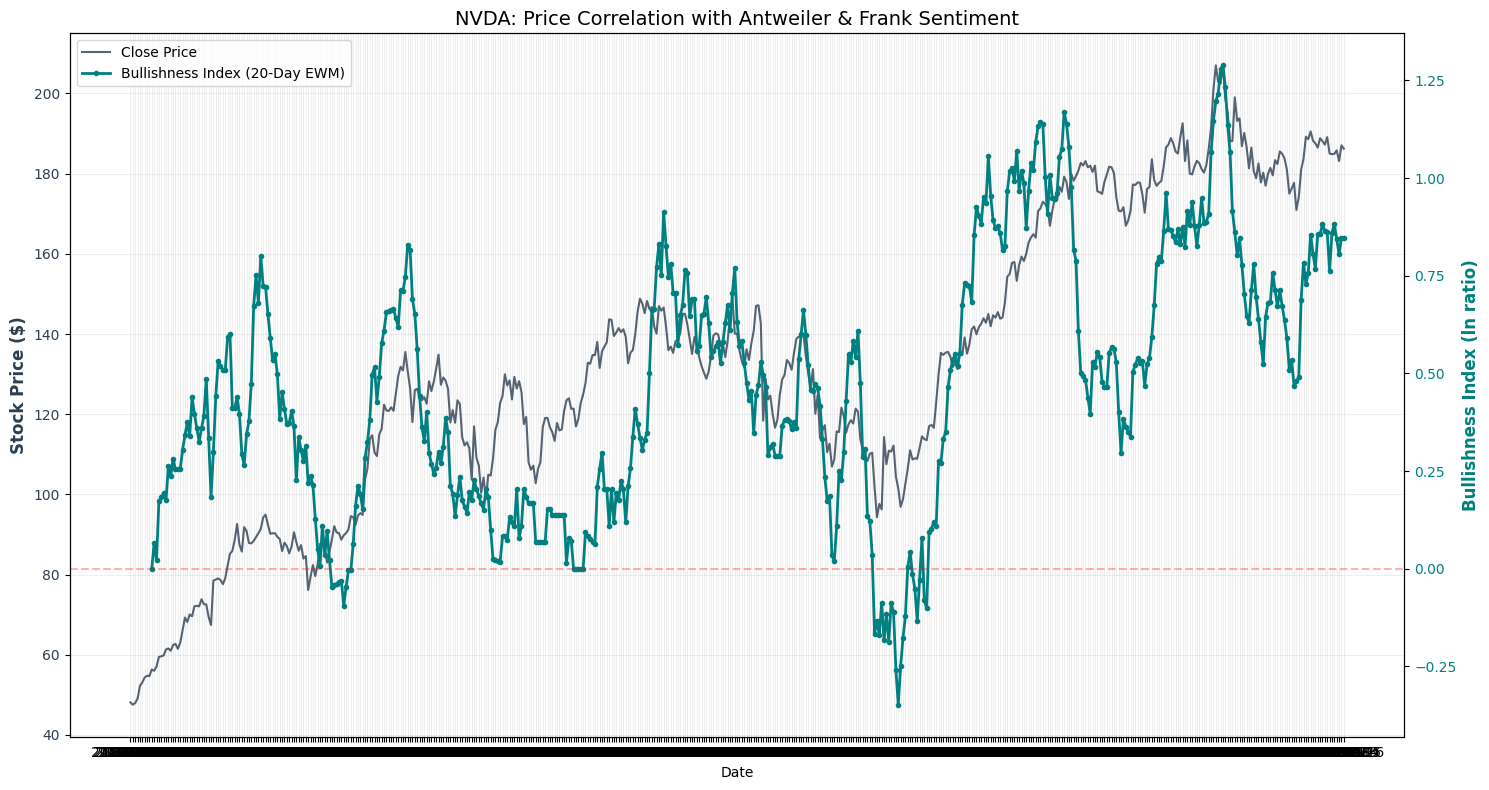

In [ ]:
import matplotlib.pyplot as plt

def plot_price_vs_sentiment(df, ticker):
    # Filter for the chosen stock
    stock_df = df[df['label'] == ticker].copy()

    min_date = min((stock_df[['date','bullishness_index']].dropna())['date'])

    stock_df = stock_df[stock_df['date']>='2024-01-01']
    
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # --- LEFT Y-AXIS: PRICE ---
    # Prices are usually continuous, so this line will likely be solid
    color_price = '#2c3e50' # Dark blue-grey
    ax1.plot(stock_df['date'], stock_df['price'], color=color_price, 
             linewidth=1.5, label='Close Price', alpha=0.8)
    
    ax1.set_ylabel('Stock Price ($)', color=color_price, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, alpha=0.2)

    # --- RIGHT Y-AXIS: BULLISHNESS ---
    # This line will break wherever 'bullishness_index' is NaN
    ax2 = ax1.twinx()
    color_bull = '#008080' # Teal
    ax2.plot(stock_df['date'], stock_df['bullishness_index'].ewm(span=20, adjust=False).mean(), color=color_bull, 
             linewidth=2, marker='o', markersize=3, label='Bullishness Index (20-Day EWM)')
    
    ax2.set_ylabel('Bullishness Index (ln ratio)', color=color_bull, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_bull)
    
    # Add a horizontal line at 0 for neutral sentiment
    ax2.axhline(0, color='red', linestyle='--', alpha=0.3)

    # Title and Legends
    plt.title(f'{ticker}: Price Correlation with Antweiler & Frank Sentiment', fontsize=14)
    ax1.set_xlabel('Date')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

# Usage:
plot_price_vs_sentiment(combined_df, 'NVDA')

In [ ]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

tech_crash_events = stock_anomaly.get_anomalies(get_dict_dates=True)

[*********************100%***********************]  5 of 5 completed
